
Import required libraries

In [55]:
# PyTorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader

# Scikit imports
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# Utils imports
import pandas as pd, numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

# Eploring Data

In [2]:
df = pd.read_csv('../Data/iris.csv')

In [3]:
df.sample(5)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
123,6.3,2.7,4.9,1.8,2.0
20,5.4,3.4,1.7,0.2,0.0
117,7.7,3.8,6.7,2.2,2.0
83,6.0,2.7,5.1,1.6,1.0
64,5.6,2.9,3.6,1.3,1.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
 4   target             150 non-null    float64
dtypes: float64(5)
memory usage: 6.0 KB


## Plotting the data

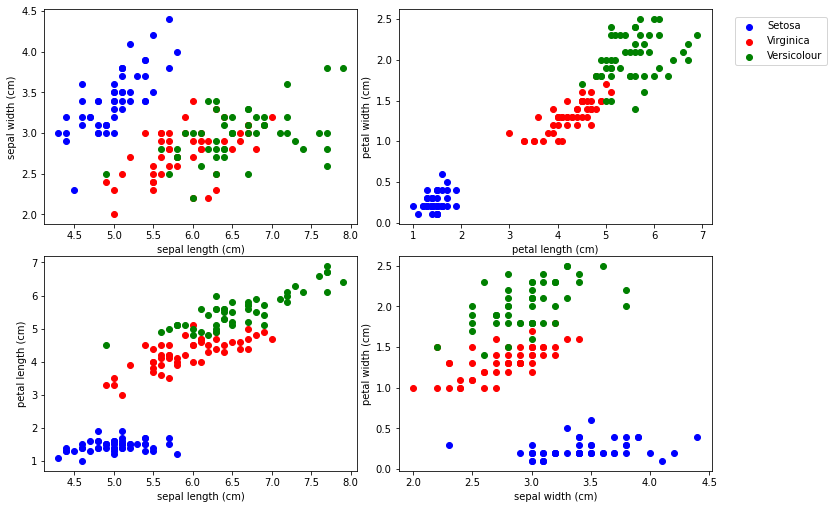

In [5]:
colours = {0:['b','Setosa'],1:['r','Virginica'],2:['g','Versicolour']}
legend = ['Setosa','Virginica','Versicolour']

fig, ax = plt.subplots(nrows=2,ncols=2,figsize=(10,7))
fig.tight_layout()
columns = [[(0,1),(2,3)],[(0,2),(1,3)]]

for i, a in enumerate(ax):
    for n,p in enumerate(a):
        for k,v in colours.items():
            x = df.columns[columns[i][n][0]]
            y = df.columns[columns[i][n][1]]
            p.scatter(df[df['target']==k][x],df[df['target']==k][y],color=v[0])
            p.set(xlabel=x,ylabel=y)

fig.legend(labels=legend,loc=3, bbox_to_anchor=(1.0,0.85));

# ANN Model

In [6]:
class Model(nn.Module):
    def __init__(self,in_features=4,h1=8,h2=9,out_features=3):
        super().__init__() # Initialise the nn.Module package
        self.fc1 = nn.Linear(in_features, h1)       # Input layer
        self.fc2 = nn.Linear(h1,h2)                 # Hidden layer
        self.out = nn.Linear(h2,out_features)       # Output layer
        
    def forward(self,x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.out(x)
        return x

In [28]:
# Instantiate the Model class using parameter defaults:
torch.manual_seed(32)
model = Model()

## Define optimisation and loss equations

We will be using Cross Entropy as our loss function (`nn.CrossEntropyLoss`) because it is a multi-class classification problem. This is how we will be measuring our error.

Adam will be used as our optimiser (`torch.optim.Adam`). We will be passing in the model parameters as a generator (`model.parameters()`), and our learning rate.

In [29]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [30]:
# model.parameters has the layers and parameters of our model
model.parameters

<bound method Module.parameters of Model(
  (fc1): Linear(in_features=4, out_features=8, bias=True)
  (fc2): Linear(in_features=8, out_features=9, bias=True)
  (out): Linear(in_features=9, out_features=3, bias=True)
)>

## Prepare Data

Splitting the data for training and testing

In [31]:
X = df.drop('target',axis=1).values
y = df['target'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=33)

Create tensors to load into the model. Given that we are using `CrossEntropyLoss` as our loss function we don't need to one-hot encode our variable for categorisation

In [32]:
# Create float tensors for features
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)

# Create a one-hot encoded variable for the categorisation of the target
#y_train = F.one_hot(torch.LongTensor(y_train))
#y_test = F.one_hot(torch.LongTensor(y_test))

# When using Cross Entropy Loss as the evaluation function one-hot encoding is not required
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

## Train the model

In [33]:
# Decide on our epochs
epochs = 200

# Create a list to store the loss for analysis
losses = []

# Create the loop that will train the model
for i in range(epochs):
    # Forward and get a prediction
    y_pred = model.forward(X_train)
    
    # Calculate the loss/error
    loss = criterion(y_pred,y_train)
    losses.append(loss.item())
    
    # Print for feedback
    if i%100==0:
        print(f'Epoch: {i}\tLoss: {loss}')
        
    # Backpropagate to adjust model weights
    optimizer.zero_grad() # Find where the gradient is zero
    loss.backward()
    optimizer.step()

Epoch: 0	Loss: 1.1507114171981812
Epoch: 100	Loss: 0.067133329808712


# Analyse training

<AxesSubplot:xlabel='epoch'>

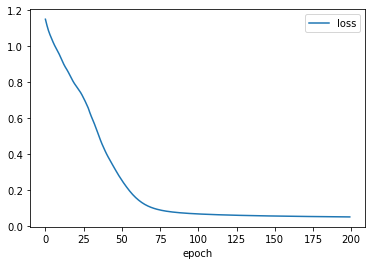

In [34]:
loss_analysis = pd.DataFrame({'epoch':range(epochs),'loss':losses})
loss_analysis.plot(x='epoch',y='loss')

<AxesSubplot:xlabel='epoch'>

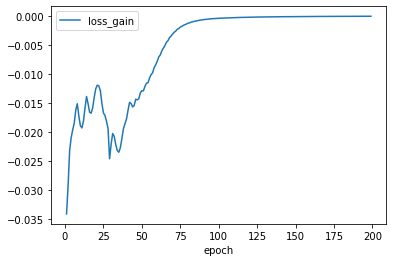

In [35]:
loss_analysis['loss_gain']=loss_analysis['loss'].diff()
loss_analysis.plot(x='epoch',y='loss_gain')

## Evaluate the model

We will evaluate the model on test data that the model has not seen before. We will need to turn off back propagation using `torch.no_grad()` as the weights do not need to be adjusted again.

In [36]:
with torch.no_grad():
    y_eval = model.forward(X_test) # Predictions
    loss = criterion(y_eval, y_test) # Calculate the loss

In [37]:
print(f'Evaluation loss: {loss.item()}')
print(f'Training loss: {loss_analysis["loss"].min()}')
print(f'Difference: {loss.item()-loss_analysis["loss"].min()}')

Evaluation loss: 0.04398542270064354
Training loss: 0.0506061352789402
Difference: -0.006620712578296661


In [46]:
predictions = y_eval.argmax(dim=1)

In [59]:
# Plot confusion matrix from predictions

cm = confusion_matrix(y_test,predictions)

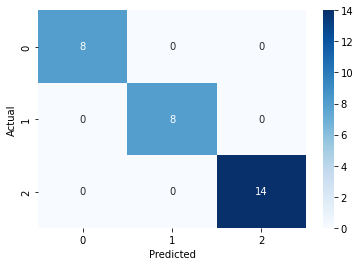

In [63]:
cm_plot = sns.heatmap(cm, annot=True, cmap='Blues')
cm_plot.set(xlabel='Predicted',ylabel='Actual');

## Savind and loading the model

Models can be saved for future use in a `.pt` file. 

They can be saved as a dictionary of parameters with `torch.save(model.state_dict(), PATH)` or the entire model with `torch.save(model,PATH)`.

The former saves the learnt parameters of the model. To load the model state into a new model the original Model class must be available. Parameters cannot be loaded to a different Model class than that which was used to save the parameters.

If the model class won't be available then the latter saving option has to be used.

In [64]:
# Save the model to a pt file
torch.save(model.state_dict(),'2022-02-05_iris_model.pt')

In [66]:
new_model = Model()
new_model.load_state_dict(torch.load('2022-02-05_iris_model.pt'))

<All keys matched successfully>

In [67]:
new_model.eval()

Model(
  (fc1): Linear(in_features=4, out_features=8, bias=True)
  (fc2): Linear(in_features=8, out_features=9, bias=True)
  (out): Linear(in_features=9, out_features=3, bias=True)
)

## Using the model in new data

In [74]:
mystery_iris = torch.tensor([5.6,3.7,2.2,0.5])

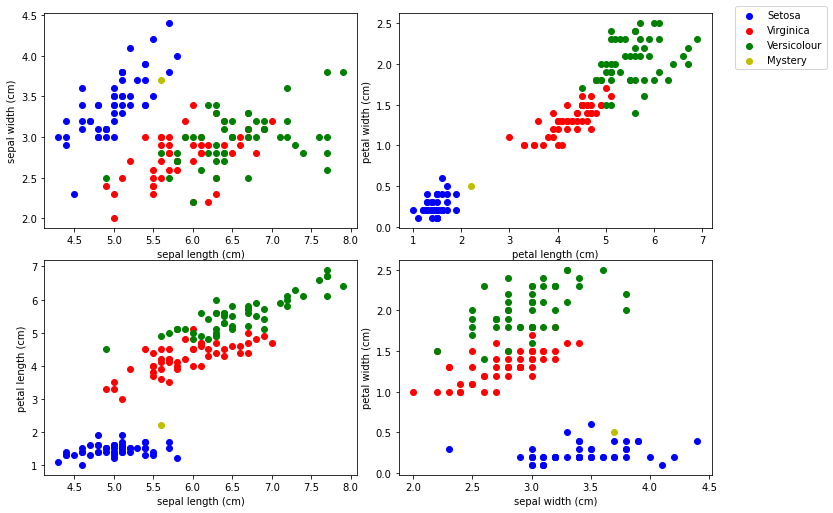

In [77]:
# Visualising where the new point would be 

colours = {0:['b','Setosa'],1:['r','Virginica'],2:['g','Versicolour']}
legend = ['Setosa','Virginica','Versicolour','Mystery']

fig, ax = plt.subplots(nrows=2,ncols=2,figsize=(10,7))
fig.tight_layout()
columns = [[(0,1),(2,3)],[(0,2),(1,3)]]

for i, a in enumerate(ax):
    for n,p in enumerate(a):
        for k,v in colours.items():
            x = df.columns[columns[i][n][0]]
            y = df.columns[columns[i][n][1]]
            p.scatter(df[df['target']==k][x],df[df['target']==k][y],color=v[0])
            p.set(xlabel=x,ylabel=y)
            
# Add new iris point
ax[0,0].scatter(mystery_iris[0],mystery_iris[1],color='y',label='Mystery')
ax[0,1].scatter(mystery_iris[2],mystery_iris[3],color='y',label='Mystery')
ax[1,0].scatter(mystery_iris[0],mystery_iris[2],color='y',label='Mystery')
ax[1,1].scatter(mystery_iris[1],mystery_iris[3],color='y',label='Mystery')

fig.legend(labels=legend,loc=3, bbox_to_anchor=(1.0,0.85));

The sample point should be 

In [84]:
with torch.no_grad():
    nm_pred = new_model.forward(mystery_iris)

nm_pred.argmax()

tensor(0)